In [1]:
from scipy.io import loadmat

# YOU SHOULD HAVE THE FOLLOWING MAT FILE !
#3years
#Data = loadmat('data/egypt_data/preprocessed data/zeros_shore_data.mat')["Values"]

#4years
Data = loadmat('data/egypt_data/preprocessed data/all4years_zeros_shore_data.mat')["Values"]

In [2]:
area = 30
timeSteps = 12

In [3]:
print(Data.shape)
#3years = 8760, 4years = 11688
Data = Data.reshape(11688,139,82,3)
print(Data.shape)

data = Data[:,:area,:area,:]
print(data.shape)

(11688, 11398, 3)
(11688, 139, 82, 3)
(11688, 30, 30, 3)


In [4]:
import numpy as np

# Assuming your data is in a variable called 'data'
# Shape of data: (8760, 139, 82, 3)
# Split your data into train, validation and test sets
train_data = data[:11000]
val_data = data[11000:11400]
test_data = data[11400:]
print(data.shape)

# Prepare your datasets
def prepare_data(data, steps):
    x, y = [], []
    for i in range(len(data)-steps-1):
        x.append(data[i:(i+steps)])
        y.append(data[i+steps][:,:,0])  # We only want to predict the first feature
    return np.array(x), np.array(y)

x_train, y_train = prepare_data(train_data, timeSteps)
x_val, y_val = prepare_data(val_data, timeSteps)
x_test, y_test = prepare_data(test_data, timeSteps)


(11688, 30, 30, 3)


In [5]:
#SHUFFLE TRAIN
indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

#SHUFFLE VALIDATION
indices = np.arange(x_val.shape[0])
np.random.shuffle(indices)
x_val = x_val[indices]
y_val = y_val[indices]

#SHUFFLE TEST
indices = np.arange(x_test.shape[0])
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]

In [9]:
np.savez('data numpy/train.npz', x_train=x_train, y_train=y_train)
np.savez('data numpy/validate.npz', x_val=x_val, y_val=y_val)
np.savez('data numpy/test.npz', x_test=x_test, y_test=y_test)

In [10]:
import numpy as np
#train=np.load('data numpy/train.npz')
val=np.load('data numpy/validate.npz')
test=np.load('data numpy/test.npz')
#x_train, y_train= train['x_train'],train['y_train']
x_val, y_val  = val['x_val'],  val['y_val']
x_test,y_test = test['x_test'],test['y_test']

In [11]:
import numpy as np
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, npz_file, batch_size):
        self.npz_file = npz_file
        self.batch_size = batch_size
        with np.load(npz_file) as data:
            self.length = data['x_train'].shape[0]

    def __len__(self):
        return int(np.ceil(self.length / float(self.batch_size)))

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        with np.load(self.npz_file) as data:
            return data['x_train'][start:end], data['y_train'][start:end]


In [12]:
train_gen= DataGenerator('data numpy/train.npz', batch_size=16)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D,Conv2D, Flatten, Dense, BatchNormalization,Reshape,Dropout,TimeDistributed,SpatialDropout2D


model = Sequential([
     ConvLSTM2D(filters=128, kernel_size=(4, 4), activation='elu', padding='same', return_sequences=True,
               input_shape=(timeSteps, 30, 30, 3)), 
     BatchNormalization(),
     ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='elu', padding='same',return_sequences=True),
     BatchNormalization(),
     ConvLSTM2D(filters=32, kernel_size=(2, 2), activation='elu', padding='same'),
     BatchNormalization(),
     #Flatten(),
     #Dense(area*area),
     #Reshape((area, area, 1)),
     Conv2D(filters=1, kernel_size=(1, 1), activation='linear'),
])

In [14]:
model.compile(optimizer='adam', loss='mse')

In [15]:
model.fit(train_gen, epochs=10,verbose = 1, validation_data=(x_val, y_val))

Epoch 1/10
687/687 [==============================] - 1112s 2s/step - loss: 0.7756 - val_loss: 0.0911
Epoch 2/10
687/687 [==============================] - 1098s 2s/step - loss: 0.0943 - val_loss: 0.0648
Epoch 3/10
687/687 [==============================] - 1091s 2s/step - loss: 0.0842 - val_loss: 0.1021
Epoch 4/10
687/687 [==============================] - 1085s 2s/step - loss: 0.0679 - val_loss: 0.0522
Epoch 5/10
687/687 [==============================] - 1090s 2s/step - loss: 0.0669 - val_loss: 0.0293
Epoch 6/10
687/687 [==============================] - 1093s 2s/step - loss: 0.0486 - val_loss: 0.1178
Epoch 7/10
687/687 [==============================] - 1087s 2s/step - loss: 0.0283 - val_loss: 0.0342
Epoch 8/10
687/687 [==============================] - 1079s 2s/step - loss: 0.0351 - val_loss: 0.0151
Epoch 9/10
687/687 [==============================] - 1080s 2s/step - loss: 0.0276 - val_loss: 0.0353
Epoch 10/10
687/687 [==============================] - 1089s 2s/step - loss: 0.027

In [16]:
test_loss = model.evaluate(x_test, y_test)
print('Test Loss: {}'.format(test_loss))

9/9 [==============================] - 3s 256ms/step - loss: 0.0228
Test Loss: 0.022793607786297798


In [17]:
x_try = x_test[0].reshape(1,timeSteps,area,area,3)
y_try = y_test[0]
y_pred = model.predict(x_try).reshape(area,area)

1/1 [==============================] - 1s 737ms/step


In [18]:
print(y_pred.shape)

(30, 30)


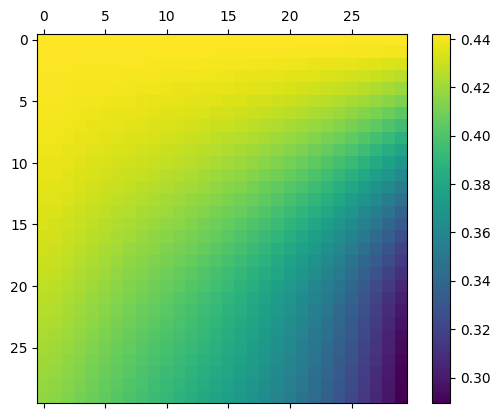

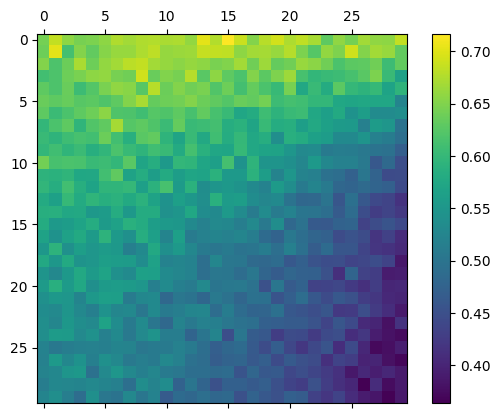

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cax = ax.matshow(y_try)
fig.colorbar(cax)
plt.show()

fig, ax = plt.subplots()
cax = ax.matshow(y_pred)
fig.colorbar(cax)
plt.show()